In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd
import numpy as np



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [2]:
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns



In [3]:
Phase_1 = convert_tsf_to_dataframe("phase_1_data.tsf")
Phase_1

(   series_name     start_timestamp  \
 0    Building0 2016-07-03 21:30:00   
 1    Building1 2019-01-09 23:15:00   
 2    Building3 2016-03-01 04:15:00   
 3    Building4 2019-07-03 04:45:00   
 4    Building5 2019-07-25 23:00:00   
 5    Building6 2019-07-25 01:45:00   
 6       Solar0 2020-04-25 14:00:00   
 7       Solar1 2018-12-31 13:00:00   
 8       Solar2 2019-06-05 14:00:00   
 9       Solar3 2019-06-05 14:00:00   
 10      Solar4 2019-06-05 14:00:00   
 11      Solar5 2019-01-15 13:00:00   
 
                                          series_value  
 0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
 1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
 2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
 3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
 4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
 5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
 6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
 7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [4]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = Phase_1
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
dataset = loaded_data.explode('series_value')
dataset

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,283.8
0,Building0,2016-07-03 21:30:00,606.0
0,Building0,2016-07-03 21:30:00,606.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,25.28
11,Solar5,2019-01-15 13:00:00,25.3
11,Solar5,2019-01-15 13:00:00,28.62
11,Solar5,2019-01-15 13:00:00,31.94


## Solar 0

In [6]:
solar_0 = dataset.loc[dataset['series_name']=='Solar0']
solar_0

,series_name,start_timestamp,series_value
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
6,Solar0,2020-04-25 14:00:00,0.0
...,...,...,...
6,Solar0,2020-04-25 14:00:00,29.67
6,Solar0,2020-04-25 14:00:00,29.94
6,Solar0,2020-04-25 14:00:00,34.02
6,Solar0,2020-04-25 14:00:00,38.1


In [7]:
import datetime

# Input start date
start_date_str = '25/04/2020 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][6])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_0['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/2285195437.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_0['start_timestamp']=datetime_column


In [8]:
solar_0 = solar_0.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_0 = solar_0[solar_0.power_output != "NaN"]
solar_0["power_output"] = pd.to_numeric(solar_0["power_output"])
solar_0

,solar_no,timestamp,power_output
6,Solar0,2020-04-25 14:00:00,0.00
6,Solar0,2020-04-25 14:15:00,0.00
6,Solar0,2020-04-25 14:30:00,0.00
6,Solar0,2020-04-25 14:45:00,0.00
6,Solar0,2020-04-25 15:00:00,0.00
...,...,...,...
6,Solar0,2020-09-30 22:45:00,29.67
6,Solar0,2020-09-30 23:00:00,29.94
6,Solar0,2020-09-30 23:15:00,34.02
6,Solar0,2020-09-30 23:30:00,38.10


## Solar 1

In [9]:
solar_1 = dataset.loc[dataset['series_name']=='Solar1']
solar_1

,series_name,start_timestamp,series_value
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
7,Solar1,2018-12-31 13:00:00,0.0
...,...,...,...
7,Solar1,2018-12-31 13:00:00,6.68
7,Solar1,2018-12-31 13:00:00,6.71
7,Solar1,2018-12-31 13:00:00,8.13
7,Solar1,2018-12-31 13:00:00,9.55


In [10]:
import datetime

# Input start date
start_date_str = '31/12/2018 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][7])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_1['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/2969204059.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_1['start_timestamp']=datetime_column


In [11]:
solar_1 = solar_1.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_1 = solar_1[solar_1.power_output != "NaN"]
solar_1["power_output"] = pd.to_numeric(solar_1["power_output"])
solar_1

,solar_no,timestamp,power_output
7,Solar1,2018-12-31 13:00:00,0.00
7,Solar1,2018-12-31 13:15:00,0.00
7,Solar1,2018-12-31 13:30:00,0.00
7,Solar1,2018-12-31 13:45:00,0.00
7,Solar1,2018-12-31 14:00:00,0.00
...,...,...,...
7,Solar1,2020-09-30 22:45:00,6.68
7,Solar1,2020-09-30 23:00:00,6.71
7,Solar1,2020-09-30 23:15:00,8.13
7,Solar1,2020-09-30 23:30:00,9.55


## Solar 2

In [12]:
solar_2 = dataset.loc[dataset['series_name']=='Solar2']
solar_2

,series_name,start_timestamp,series_value
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
8,Solar2,2019-06-05 14:00:00,0.0
...,...,...,...
8,Solar2,2019-06-05 14:00:00,6.34
8,Solar2,2019-06-05 14:00:00,6.39
8,Solar2,2019-06-05 14:00:00,7.71
8,Solar2,2019-06-05 14:00:00,9.03


In [13]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][8])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_2['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/2501473815.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_2['start_timestamp']=datetime_column


In [14]:
solar_2 = solar_2.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_2 = solar_2[solar_2.power_output != "NaN"]
solar_2["power_output"] = pd.to_numeric(solar_2["power_output"])
solar_2

,solar_no,timestamp,power_output
8,Solar2,2019-06-05 14:00:00,0.00
8,Solar2,2019-06-05 14:15:00,0.00
8,Solar2,2019-06-05 14:30:00,0.00
8,Solar2,2019-06-05 14:45:00,0.00
8,Solar2,2019-06-05 15:00:00,0.00
...,...,...,...
8,Solar2,2020-09-30 22:45:00,6.34
8,Solar2,2020-09-30 23:00:00,6.39
8,Solar2,2020-09-30 23:15:00,7.71
8,Solar2,2020-09-30 23:30:00,9.03


## Solar 3

In [15]:
solar_3 = dataset.loc[dataset['series_name']=='Solar3']
solar_3

,series_name,start_timestamp,series_value
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
9,Solar3,2019-06-05 14:00:00,0.0
...,...,...,...
9,Solar3,2019-06-05 14:00:00,5.49
9,Solar3,2019-06-05 14:00:00,5.65
9,Solar3,2019-06-05 14:00:00,6.83
9,Solar3,2019-06-05 14:00:00,8.02


In [16]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][9])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_3['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/2686233820.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_3['start_timestamp']=datetime_column


In [17]:
solar_3 = solar_3.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_3 = solar_3[solar_3.power_output != "NaN"]
solar_3["power_output"] = pd.to_numeric(solar_3["power_output"])
solar_3

,solar_no,timestamp,power_output
9,Solar3,2019-06-05 14:00:00,0.00
9,Solar3,2019-06-05 14:15:00,0.00
9,Solar3,2019-06-05 14:30:00,0.00
9,Solar3,2019-06-05 14:45:00,0.00
9,Solar3,2019-06-05 15:00:00,0.00
...,...,...,...
9,Solar3,2020-09-30 22:45:00,5.49
9,Solar3,2020-09-30 23:00:00,5.65
9,Solar3,2020-09-30 23:15:00,6.83
9,Solar3,2020-09-30 23:30:00,8.02


## Solar 4

In [18]:
solar_4 = dataset.loc[dataset['series_name']=='Solar4']
solar_4

,series_name,start_timestamp,series_value
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
10,Solar4,2019-06-05 14:00:00,0.0
...,...,...,...
10,Solar4,2019-06-05 14:00:00,4.55
10,Solar4,2019-06-05 14:00:00,4.57
10,Solar4,2019-06-05 14:00:00,5.32
10,Solar4,2019-06-05 14:00:00,6.08


In [19]:
import datetime

# Input start date
start_date_str = '05/06/2019 14:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][10])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_4['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/601097210.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_4['start_timestamp']=datetime_column


In [20]:
solar_4 = solar_4.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_4 = solar_4[solar_4.power_output != "NaN"]
solar_4["power_output"] = pd.to_numeric(solar_4["power_output"])
solar_4

,solar_no,timestamp,power_output
10,Solar4,2019-06-05 14:00:00,0.00
10,Solar4,2019-06-05 14:15:00,0.00
10,Solar4,2019-06-05 14:30:00,0.00
10,Solar4,2019-06-05 14:45:00,0.00
10,Solar4,2019-06-05 15:00:00,0.00
...,...,...,...
10,Solar4,2020-09-30 22:45:00,4.55
10,Solar4,2020-09-30 23:00:00,4.57
10,Solar4,2020-09-30 23:15:00,5.32
10,Solar4,2020-09-30 23:30:00,6.08


## Solar 5

In [21]:
solar_5 = dataset.loc[dataset['series_name']=='Solar5']
solar_5

,series_name,start_timestamp,series_value
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
11,Solar5,2019-01-15 13:00:00,0.0
...,...,...,...
11,Solar5,2019-01-15 13:00:00,25.28
11,Solar5,2019-01-15 13:00:00,25.3
11,Solar5,2019-01-15 13:00:00,28.62
11,Solar5,2019-01-15 13:00:00,31.94


In [22]:
import datetime

# Input start date
start_date_str = '15/01/2019 13:00:00'
start_date = datetime.datetime.strptime(start_date_str, '%d/%m/%Y %H:%M:%S')

# Interval duration
interval_duration = datetime.timedelta(minutes=15)

# Number of intervals
num_intervals = len(loaded_data['series_value'][11])

# Calculate the end date
end_date = start_date + interval_duration * (num_intervals-1)

# Print the end date
# print("End Date:", end_date.strftime('%d/%m/%Y %H:%M:%S'))
end_date_str = '30/09/2020 23:45:00'

# Convert start and end date strings to datetime objects
end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')

#building_0['start_timestamp']=datetime_column
solar_5['start_timestamp']=datetime_column

/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/2778311694.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_5['start_timestamp']=datetime_column


In [23]:
solar_5 = solar_5.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
solar_5 = solar_5[solar_5.power_output != "NaN"]
solar_5["power_output"] = pd.to_numeric(solar_5["power_output"])
solar_5

,solar_no,timestamp,power_output
11,Solar5,2019-01-15 13:00:00,0.00
11,Solar5,2019-01-15 13:15:00,0.00
11,Solar5,2019-01-15 13:30:00,0.00
11,Solar5,2019-01-15 13:45:00,0.00
11,Solar5,2019-01-15 14:00:00,0.00
...,...,...,...
11,Solar5,2020-09-30 22:45:00,25.28
11,Solar5,2020-09-30 23:00:00,25.30
11,Solar5,2020-09-30 23:15:00,28.62
11,Solar5,2020-09-30 23:30:00,31.94


## combining weather data with the solar data

### indexing timestamp

In [24]:
solar_0 = solar_0.set_index(pd.DatetimeIndex(solar_0['timestamp'])).drop(solar_0.columns[1], axis=1)
solar_0

,solar_no,power_output
timestamp,,
2020-04-25 14:00:00,Solar0,0.00
2020-04-25 14:15:00,Solar0,0.00
2020-04-25 14:30:00,Solar0,0.00
2020-04-25 14:45:00,Solar0,0.00
2020-04-25 15:00:00,Solar0,0.00
...,...,...
2020-09-30 22:45:00,Solar0,29.67
2020-09-30 23:00:00,Solar0,29.94
2020-09-30 23:15:00,Solar0,34.02


In [25]:
solar_1 = solar_1.set_index(pd.DatetimeIndex(solar_1['timestamp'])).drop(solar_1.columns[1], axis=1)
solar_1

,solar_no,power_output
timestamp,,
2018-12-31 13:00:00,Solar1,0.00
2018-12-31 13:15:00,Solar1,0.00
2018-12-31 13:30:00,Solar1,0.00
2018-12-31 13:45:00,Solar1,0.00
2018-12-31 14:00:00,Solar1,0.00
...,...,...
2020-09-30 22:45:00,Solar1,6.68
2020-09-30 23:00:00,Solar1,6.71
2020-09-30 23:15:00,Solar1,8.13


In [26]:
solar_2 = solar_2.set_index(pd.DatetimeIndex(solar_2['timestamp'])).drop(solar_2.columns[1], axis=1)
solar_2

,solar_no,power_output
timestamp,,
2019-06-05 14:00:00,Solar2,0.00
2019-06-05 14:15:00,Solar2,0.00
2019-06-05 14:30:00,Solar2,0.00
2019-06-05 14:45:00,Solar2,0.00
2019-06-05 15:00:00,Solar2,0.00
...,...,...
2020-09-30 22:45:00,Solar2,6.34
2020-09-30 23:00:00,Solar2,6.39
2020-09-30 23:15:00,Solar2,7.71


In [27]:
solar_3 = solar_3.set_index(pd.DatetimeIndex(solar_3['timestamp'])).drop(solar_3.columns[1], axis=1)
solar_3

,solar_no,power_output
timestamp,,
2019-06-05 14:00:00,Solar3,0.00
2019-06-05 14:15:00,Solar3,0.00
2019-06-05 14:30:00,Solar3,0.00
2019-06-05 14:45:00,Solar3,0.00
2019-06-05 15:00:00,Solar3,0.00
...,...,...
2020-09-30 22:45:00,Solar3,5.49
2020-09-30 23:00:00,Solar3,5.65
2020-09-30 23:15:00,Solar3,6.83


In [28]:
solar_4 = solar_4.set_index(pd.DatetimeIndex(solar_4['timestamp'])).drop(solar_4.columns[1], axis=1)
solar_4

,solar_no,power_output
timestamp,,
2019-06-05 14:00:00,Solar4,0.00
2019-06-05 14:15:00,Solar4,0.00
2019-06-05 14:30:00,Solar4,0.00
2019-06-05 14:45:00,Solar4,0.00
2019-06-05 15:00:00,Solar4,0.00
...,...,...
2020-09-30 22:45:00,Solar4,4.55
2020-09-30 23:00:00,Solar4,4.57
2020-09-30 23:15:00,Solar4,5.32


In [29]:
solar_5 = solar_5.set_index(pd.DatetimeIndex(solar_5['timestamp'])).drop(solar_5.columns[1], axis=1)
solar_5

,solar_no,power_output
timestamp,,
2019-01-15 13:00:00,Solar5,0.00
2019-01-15 13:15:00,Solar5,0.00
2019-01-15 13:30:00,Solar5,0.00
2019-01-15 13:45:00,Solar5,0.00
2019-01-15 14:00:00,Solar5,0.00
...,...,...
2020-09-30 22:45:00,Solar5,25.28
2020-09-30 23:00:00,Solar5,25.30
2020-09-30 23:15:00,Solar5,28.62


### combining stuff

In [30]:
weather = pd.read_csv("ERA5_Weather_Data_Monash.csv")
weather

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100052,2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,2021-05-31 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [31]:
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather

,"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,,,
2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00


In [32]:
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,
2010-01-01 00:00:00,69.6,10.0,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,69.6,10.0,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:00:00,69.6,10.0,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-05-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
weather.isna().sum()

model elevation (surface)            300168
utc_offset (hrs)                     300168
temperature (degC)                   300168
dewpoint_temperature (degC)          300168
wind_speed (m/s)                     300168
mean_sea_level_pressure (Pa)         300168
relative_humidity ((0-1))            300168
surface_solar_radiation (W/m^2)      300168
surface_thermal_radiation (W/m^2)    300168
total_cloud_cover (0-1)              300168
dtype: int64

In [34]:
weather = weather.interpolate(method='linear') #Input NaN
weather

,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,,,
2010-01-01 00:00:00,69.6,10.0,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 00:15:00,69.6,10.0,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 00:30:00,69.6,10.0,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 00:45:00,69.6,10.0,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 01:00:00,69.6,10.0,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-31 23:00:00,69.6,10.0,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-05-31 23:15:00,69.6,10.0,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-05-31 23:30:00,69.6,10.0,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [35]:
weather.isna().sum()

model elevation (surface)            0
utc_offset (hrs)                     0
temperature (degC)                   0
dewpoint_temperature (degC)          0
wind_speed (m/s)                     0
mean_sea_level_pressure (Pa)         0
relative_humidity ((0-1))            0
surface_solar_radiation (W/m^2)      0
surface_thermal_radiation (W/m^2)    0
total_cloud_cover (0-1)              0
dtype: int64

In [36]:
weather.index.names = ['timestamp']
# weather

In [37]:
solar0 = pd.merge(solar_0, weather, left_index=True, right_index=True)
solar0

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2020-04-25 14:00:00,Solar0,0.00,69.6,10.0,16.100,13.600,6.300,101156.400,0.800,0.000,366.900,1.000
2020-04-25 14:15:00,Solar0,0.00,69.6,10.0,16.075,13.725,6.175,101130.075,0.825,0.000,367.325,1.000
2020-04-25 14:30:00,Solar0,0.00,69.6,10.0,16.050,13.850,6.050,101103.750,0.850,0.000,367.750,1.000
2020-04-25 14:45:00,Solar0,0.00,69.6,10.0,16.025,13.975,5.925,101077.425,0.875,0.000,368.175,1.000
2020-04-25 15:00:00,Solar0,0.00,69.6,10.0,16.000,14.100,5.800,101051.100,0.900,0.000,368.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,Solar0,29.67,69.6,10.0,11.825,6.825,5.000,101674.375,0.725,367.350,282.550,0.350
2020-09-30 23:00:00,Solar0,29.94,69.6,10.0,12.100,6.800,5.100,101692.500,0.700,406.400,282.700,0.400
2020-09-30 23:15:00,Solar0,34.02,69.6,10.0,12.300,6.675,5.050,101699.950,0.675,444.875,282.200,0.425


In [38]:
solar1 = pd.merge(solar_1, weather, left_index=True, right_index=True)
solar1

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2018-12-31 13:00:00,Solar1,0.00,69.6,10.0,16.300,12.400,3.10,101292.900,0.800,0.000,330.600,0.000
2018-12-31 13:15:00,Solar1,0.00,69.6,10.0,16.100,12.425,3.00,101283.875,0.800,0.000,329.575,0.025
2018-12-31 13:30:00,Solar1,0.00,69.6,10.0,15.900,12.450,2.90,101274.850,0.800,0.000,328.550,0.050
2018-12-31 13:45:00,Solar1,0.00,69.6,10.0,15.700,12.475,2.80,101265.825,0.800,0.000,327.525,0.075
2018-12-31 14:00:00,Solar1,0.00,69.6,10.0,15.500,12.500,2.70,101256.800,0.800,0.000,326.500,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,Solar1,6.68,69.6,10.0,11.825,6.825,5.00,101674.375,0.725,367.350,282.550,0.350
2020-09-30 23:00:00,Solar1,6.71,69.6,10.0,12.100,6.800,5.10,101692.500,0.700,406.400,282.700,0.400
2020-09-30 23:15:00,Solar1,8.13,69.6,10.0,12.300,6.675,5.05,101699.950,0.675,444.875,282.200,0.425


In [39]:
solar2 = pd.merge(solar_2, weather, left_index=True, right_index=True)
solar2

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-06-05 14:00:00,Solar2,0.00,69.6,10.0,10.100,7.100,4.70,100914.100,0.800,0.000,346.500,1.000
2019-06-05 14:15:00,Solar2,0.00,69.6,10.0,10.150,7.200,4.70,100910.350,0.800,0.000,348.525,1.000
2019-06-05 14:30:00,Solar2,0.00,69.6,10.0,10.200,7.300,4.70,100906.600,0.800,0.000,350.550,1.000
2019-06-05 14:45:00,Solar2,0.00,69.6,10.0,10.250,7.400,4.70,100902.850,0.800,0.000,352.575,1.000
2019-06-05 15:00:00,Solar2,0.00,69.6,10.0,10.300,7.500,4.70,100899.100,0.800,0.000,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,Solar2,6.34,69.6,10.0,11.825,6.825,5.00,101674.375,0.725,367.350,282.550,0.350
2020-09-30 23:00:00,Solar2,6.39,69.6,10.0,12.100,6.800,5.10,101692.500,0.700,406.400,282.700,0.400
2020-09-30 23:15:00,Solar2,7.71,69.6,10.0,12.300,6.675,5.05,101699.950,0.675,444.875,282.200,0.425


In [40]:
solar3 = pd.merge(solar_3, weather, left_index=True, right_index=True)
solar3

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-06-05 14:00:00,Solar3,0.00,69.6,10.0,10.100,7.100,4.70,100914.100,0.800,0.000,346.500,1.000
2019-06-05 14:15:00,Solar3,0.00,69.6,10.0,10.150,7.200,4.70,100910.350,0.800,0.000,348.525,1.000
2019-06-05 14:30:00,Solar3,0.00,69.6,10.0,10.200,7.300,4.70,100906.600,0.800,0.000,350.550,1.000
2019-06-05 14:45:00,Solar3,0.00,69.6,10.0,10.250,7.400,4.70,100902.850,0.800,0.000,352.575,1.000
2019-06-05 15:00:00,Solar3,0.00,69.6,10.0,10.300,7.500,4.70,100899.100,0.800,0.000,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,Solar3,5.49,69.6,10.0,11.825,6.825,5.00,101674.375,0.725,367.350,282.550,0.350
2020-09-30 23:00:00,Solar3,5.65,69.6,10.0,12.100,6.800,5.10,101692.500,0.700,406.400,282.700,0.400
2020-09-30 23:15:00,Solar3,6.83,69.6,10.0,12.300,6.675,5.05,101699.950,0.675,444.875,282.200,0.425


In [41]:
solar4 = pd.merge(solar_4, weather, left_index=True, right_index=True)
solar4

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-06-05 14:00:00,Solar4,0.00,69.6,10.0,10.100,7.100,4.70,100914.100,0.800,0.000,346.500,1.000
2019-06-05 14:15:00,Solar4,0.00,69.6,10.0,10.150,7.200,4.70,100910.350,0.800,0.000,348.525,1.000
2019-06-05 14:30:00,Solar4,0.00,69.6,10.0,10.200,7.300,4.70,100906.600,0.800,0.000,350.550,1.000
2019-06-05 14:45:00,Solar4,0.00,69.6,10.0,10.250,7.400,4.70,100902.850,0.800,0.000,352.575,1.000
2019-06-05 15:00:00,Solar4,0.00,69.6,10.0,10.300,7.500,4.70,100899.100,0.800,0.000,354.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,Solar4,4.55,69.6,10.0,11.825,6.825,5.00,101674.375,0.725,367.350,282.550,0.350
2020-09-30 23:00:00,Solar4,4.57,69.6,10.0,12.100,6.800,5.10,101692.500,0.700,406.400,282.700,0.400
2020-09-30 23:15:00,Solar4,5.32,69.6,10.0,12.300,6.675,5.05,101699.950,0.675,444.875,282.200,0.425


In [42]:
solar5 = pd.merge(solar_5, weather, left_index=True, right_index=True)
solar5

,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,,,,,
2019-01-15 13:00:00,Solar5,0.00,69.6,10.0,22.700,15.500,1.600,100821.700,0.600,0.000,346.000,0.000
2019-01-15 13:15:00,Solar5,0.00,69.6,10.0,22.575,15.525,2.175,100839.525,0.625,0.000,345.975,0.000
2019-01-15 13:30:00,Solar5,0.00,69.6,10.0,22.450,15.550,2.750,100857.350,0.650,0.000,345.950,0.000
2019-01-15 13:45:00,Solar5,0.00,69.6,10.0,22.325,15.575,3.325,100875.175,0.675,0.000,345.925,0.000
2019-01-15 14:00:00,Solar5,0.00,69.6,10.0,22.200,15.600,3.900,100893.000,0.700,0.000,345.900,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,Solar5,25.28,69.6,10.0,11.825,6.825,5.000,101674.375,0.725,367.350,282.550,0.350
2020-09-30 23:00:00,Solar5,25.30,69.6,10.0,12.100,6.800,5.100,101692.500,0.700,406.400,282.700,0.400
2020-09-30 23:15:00,Solar5,28.62,69.6,10.0,12.300,6.675,5.050,101699.950,0.675,444.875,282.200,0.425


In [43]:
def time_change_data(timeseries,solar_number):
    timestamp_series= pd.to_datetime(timeseries)

    # Extract the day and time parts using dt accessor
    day_part = timestamp_series.dt.strftime("%Y-%m-%d")
    time_part= timestamp_series.dt.strftime("%H:%M:%S")

    # Create a DataFrame to display the results
    result_df= pd.DataFrame({
        "Day": day_part,
        "Solar": solar_number["power_output"]
    })
    result_df_sum=result_df.groupby('Day').sum()
    return result_df_sum

In [44]:
solar0=solar0.reset_index()
solar0

,timestamp,solar_no,power_output,model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2020-04-25 14:00:00,Solar0,0.00,69.6,10.0,16.100,13.600,6.300,101156.400,0.800,0.000,366.900,1.000
1,2020-04-25 14:15:00,Solar0,0.00,69.6,10.0,16.075,13.725,6.175,101130.075,0.825,0.000,367.325,1.000
2,2020-04-25 14:30:00,Solar0,0.00,69.6,10.0,16.050,13.850,6.050,101103.750,0.850,0.000,367.750,1.000
3,2020-04-25 14:45:00,Solar0,0.00,69.6,10.0,16.025,13.975,5.925,101077.425,0.875,0.000,368.175,1.000
4,2020-04-25 15:00:00,Solar0,0.00,69.6,10.0,16.000,14.100,5.800,101051.100,0.900,0.000,368.600,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15203,2020-09-30 22:45:00,Solar0,29.67,69.6,10.0,11.825,6.825,5.000,101674.375,0.725,367.350,282.550,0.350
15204,2020-09-30 23:00:00,Solar0,29.94,69.6,10.0,12.100,6.800,5.100,101692.500,0.700,406.400,282.700,0.400
15205,2020-09-30 23:15:00,Solar0,34.02,69.6,10.0,12.300,6.675,5.050,101699.950,0.675,444.875,282.200,0.425
15206,2020-09-30 23:30:00,Solar0,38.10,69.6,10.0,12.500,6.550,5.000,101707.400,0.650,483.350,281.700,0.450


/var/folders/8s/9tq1cw9n5p9ctt215htgjcw40000gn/T/ipykernel_21819/3370858628.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal


(11.5, -0.5)

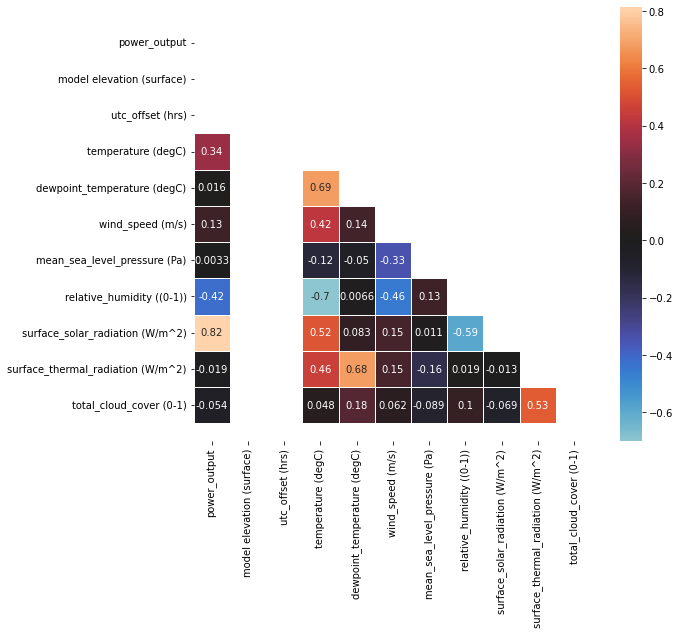

In [45]:
corrs = solar0.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool)) # create a mask to only show entries below the main diagonal
f, ax = plt.subplots(figsize=(10, 8))
# plot the heatmap with a colour bar
sns.heatmap(corrs, mask=mask, center=0, annot=True, square=True, linewidths=.5)
# adjust the top and bottom, so that we can see the whole figure
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [46]:
def train_split_mod(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.

    # Create a table of the various scores.
    result=pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return result

# solar 0

In [47]:
# solar0

In [48]:
# timestamp_series0 = pd.Series(solar0['timestamp'])
# result_df_sum0=time_change_data(timestamp_series0,solar0)
# result_df_sum0.plot.line(figsize=(14,4))

In [49]:
X = solar0.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y = solar0['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)  # Keeps the 'random' split consistent.

In [50]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.680780,5.027214,2.845612
test,0.686126,4.873592,2.776176


# Solar 1

### solar 1 start

In [51]:
# solar1

In [52]:
X1 = solar1.drop(['power_output','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y1 = solar1['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2,random_state=42) 

In [53]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.421137,2.614823,1.718193
test,0.421821,2.604544,1.703173


## solar 1 mid

In [54]:
solar1_mid=solar1.reset_index()

selected_rows = solar1_mid[solar1_mid['timestamp'] >= '2019-06-05']
# selected_rows

In [55]:
X1_1 = selected_rows.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y1_1 = selected_rows['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X1_1, Y1_1, test_size=0.2,random_state=42) 

In [56]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.484352,2.540114,1.719316
test,0.497313,2.540742,1.723400


## solar 1 end

In [57]:
solar1_end=solar1.reset_index()

selected_rows_1 = solar1_end[solar1_end['timestamp'] >= '2020-04-25']
# selected_rows_1

In [58]:
X1_2 = selected_rows_1.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y1_2 = selected_rows_1['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X1_2, Y1_2, test_size=0.2,random_state=42) 

In [59]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.416933,2.578650,1.955626
test,0.417842,2.551456,1.929509


# solar 2

## solar 2 start

In [60]:
X2 = solar2.drop(['power_output','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y2 = solar2['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size=0.2,random_state=42) 

In [61]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.638591,1.874845,1.182211
test,0.651906,1.855110,1.179317


## solar 2 mid

In [62]:
solar2_mid=solar2.reset_index()

selected_rows = solar2_mid[solar2_mid['timestamp'] >= '2019-06-05']

In [63]:
X2_1 = selected_rows.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y2_1 = selected_rows['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X2_1, Y2_1, test_size=0.2,random_state=42) 

In [64]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.638591,1.874845,1.182211
test,0.651906,1.855110,1.179317


## Solar 2 end

In [65]:
solar2_end=solar2.reset_index()

selected_rows_1 = solar2_end[solar2_end['timestamp'] >= '2020-04-25']
# selected_rows_1

In [66]:
X2_2 = selected_rows_1.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y2_2 = selected_rows_1['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X2_2, Y2_2, test_size=0.2,random_state=42) 

In [67]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.614052,1.585510,1.199821
test,0.614612,1.563082,1.180041


# Solar 3

## solar 3 start

In [68]:
X3 = solar3.drop(['power_output','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y3 = solar3['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y3, test_size=0.2,random_state=42) 

In [69]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.559463,1.467640,0.891171
test,0.576554,1.445759,0.875288


## solar 3 end

In [70]:
solar3_end=solar3.reset_index()

selected_rows_1 = solar3_end[solar3_end['timestamp'] >= '2020-04-25']

In [71]:
X3_2 = selected_rows_1.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y3_2 = selected_rows_1['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X3_2, Y3_2, test_size=0.2,random_state=42) 

In [72]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.735800,1.135453,0.716303
test,0.735104,1.117894,0.697897


# solar 4

## solar 4 satrt

In [73]:
X4 = solar4.drop(['power_output','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y4 = solar4['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X4, Y4, test_size=0.2,random_state=42) 

In [74]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.696388,1.041742,0.648319
test,0.707643,1.029732,0.643758


## solar 4 end

In [75]:
solar4_end=solar4.reset_index()

selected_rows_1 = solar4_end[solar4_end['timestamp'] >= '2020-04-25']

In [76]:
X4_2 = selected_rows_1.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y4_2 = selected_rows_1['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X4_2, Y4_2, test_size=0.2,random_state=42) 

In [77]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.697340,0.792946,0.569198
test,0.693593,0.785024,0.558581


# solar 5

## solar 5 start

In [78]:
X5 = solar5.drop(['power_output','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y5 = solar5['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X5, Y5, test_size=0.2,random_state=42) 

In [79]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.459034,6.424266,3.756025
test,0.474118,6.371795,3.721068


## solar 5 mid

In [80]:
solar5_mid=solar5.reset_index()

selected_rows = solar5_mid[solar5_mid['timestamp'] >= '2019-06-05']
X5_1 = selected_rows.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y5_1 = selected_rows['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X2_1, Y2_1, test_size=0.2,random_state=42) 

In [81]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.638591,1.874845,1.182211
test,0.651906,1.855110,1.179317


## solar 5 end

In [82]:
solar5_end=solar5.reset_index()

selected_rows_1 = solar5_end[solar5_end['timestamp'] >= '2020-04-25']
X5_2 = selected_rows_1.drop(['power_output','timestamp','solar_no'],axis=1)  # Create a Dataframe without the target variable Y.
Y5_2 = selected_rows_1['power_output']
X_train, X_test, Y_train, Y_test = train_test_split(X5_2, Y5_2, test_size=0.2,random_state=42) 

In [83]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.722336,4.447732,2.643938
test,0.739490,4.269100,2.570631
